In [38]:
import pandas as pd
import numpy as np

%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import __version__
print(__version__)

2.4.3


In [39]:
ratings = pd.read_csv('/content/sample_data/ratings.csv', sep='\t', encoding='latin-1', 
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

In [40]:
ratings

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
...,...,...,...,...,...
1000204,6040,1091,1,6039,1090
1000205,6040,1094,5,6039,1093
1000206,6040,562,5,6039,561
1000207,6040,1096,4,6039,1095


In [41]:
max_userid = ratings['user_id'].drop_duplicates().max()
max_movieid = ratings['movie_id'].drop_duplicates().max()
print(max_userid)
print(max_movieid)

6040
3952


In [42]:
users = pd.read_csv('/content/sample_data/users.csv', sep='\t', encoding='latin-1', 
                    usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

In [43]:
users

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer
...,...,...,...,...,...
6035,6036,F,32603,25-34,scientist
6036,6037,F,76006,45-49,academic/educator
6037,6038,F,14706,56+,academic/educator
6038,6039,F,01060,45-49,other or not specified


In [44]:
movies = pd.read_csv('/content/sample_data/movies.csv', sep='\t', encoding='latin-1', 
                     usecols=['movie_id', 'title', 'genres'])

In [45]:
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [46]:

# Create training set
RNG_SEED = 32
shuffled_ratings = ratings.sample(frac=1., random_state=RNG_SEED)

# Shuffling users
Users = shuffled_ratings['user_emb_id'].values
print('Users:', Users, ', shape =', Users.shape)

# Shuffling movies
Movies = shuffled_ratings['movie_emb_id'].values
print('Movies:', Movies, ', shape =', Movies.shape)

# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
print('Ratings:', Ratings, ', shape =', Ratings.shape)

Users: [3620 2624 1259 ... 3945 2164   80] , shape = (1000209,)
Movies: [3571 1993 3504 ... 2139 3267  110] , shape = (1000209,)
Ratings: [1 3 4 ... 4 3 5] , shape = (1000209,)


Mike's Model

In [14]:
# import numpy as np
# import tensorflow as tf

# from keras.layers import Embedding, Reshape, dot
# from keras.models import Sequential

# class CFModel(Sequential):

#     # The constructor for the class
#     def __init__(self, n_users, m_items, k_factors, **kwargs):
#         # P is the embedding layer that creates an User by latent factors matrix.
#         # If the intput is a user_id, P returns the latent factor vector for that user.
#         P = Sequential()
#         P.add(Embedding(n_users, k_factors, input_length=1))
#         P.add(Reshape((k_factors,)))

#         # Q is the embedding layer that creates a Movie by latent factors matrix.
#         # If the input is a movie_id, Q returns the latent factor vector for that movie.
#         Q = Sequential()
#         Q.add(Embedding(m_items, k_factors, input_length=1))
#         Q.add(Reshape((k_factors,)))

#         super(CFModel, self).__init__(**kwargs)
        
#         # The Merge layer takes the dot product of user and movie latent factor vectors to return the corresponding rating.
#         keras.layers.dot([P, Q], axes=1)
        
#     # The rate function to predict user's rating of unrated items
#     def rate(self, user_id, item_id):
#         return self.predict([np.array([user_id]), np.array([item_id])])[0][0]


In [15]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Reshape, Concatenate, dot
from keras import Input
from keras.optimizers import Adagrad

k_factors = 100
input_1 = Input(shape=(1,))
input_2 = Input(shape=(1,))
P = Reshape((k_factors,))(Embedding(max_userid, k_factors, input_length=1)(input_1))
Q = Reshape((k_factors,))(Embedding(max_movieid, k_factors, input_length=1)(input_2))
P_dot_Q = dot([P, Q], axes=1, normalize=True)
model = Model(inputs=[input_1, input_2], outputs=P_dot_Q)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       94900       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       395200      input_2[0][0]                    
______________________________________________________________________________________________

In [17]:
import tensorflow as tf

def plot_model(model):
  return tf.keras.utils.plot_model(
            model, show_shapes=True, expand_nested=True)

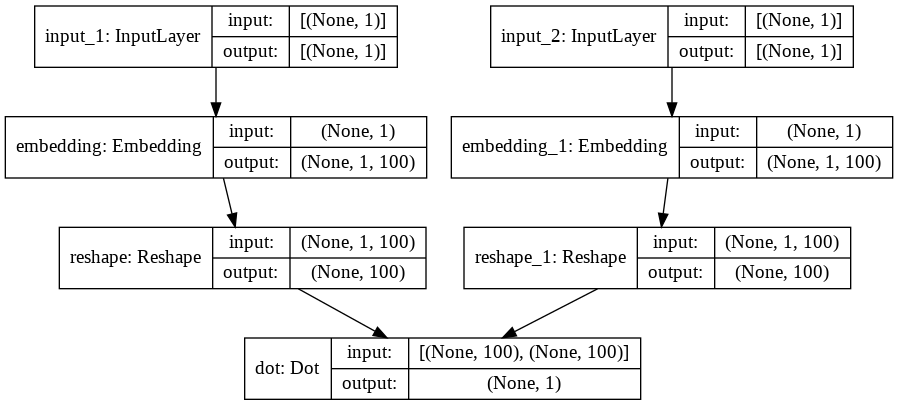

In [18]:
plot_model(model)

In [19]:
from keras.models import load_model
import os
def save_model(model, name):
  model_name = '{}.h5'.format(name)
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  
  # Save model and weights
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at %s ' % model_path)

In [20]:
save_model(model, 'weights') #save baseline CNN model

Saved trained model at /content/saved_models/weights.h5 


In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model.compile(loss='mse', optimizer='adamax')
callbacks = [EarlyStopping('val_loss', patience=2), ModelCheckpoint('weights.h5', save_best_only=True)]

In [24]:
history = model.fit([Users, Movies], Ratings, epochs=30, validation_split=.1, verbose=2, callbacks=callbacks)

Epoch 1/30
4150/4150 - 12s - loss: 14.0746 - val_loss: 13.8577
Epoch 2/30
4150/4150 - 10s - loss: 12.7149 - val_loss: 11.4930
Epoch 3/30
4150/4150 - 10s - loss: 10.3391 - val_loss: 9.6154
Epoch 4/30
4150/4150 - 10s - loss: 9.1442 - val_loss: 8.8604
Epoch 5/30
4150/4150 - 10s - loss: 8.6436 - val_loss: 8.5166
Epoch 6/30
4150/4150 - 10s - loss: 8.3994 - val_loss: 8.3345
Epoch 7/30
4150/4150 - 10s - loss: 8.2631 - val_loss: 8.2270
Epoch 8/30
4150/4150 - 9s - loss: 8.1797 - val_loss: 8.1583
Epoch 9/30
4150/4150 - 10s - loss: 8.1248 - val_loss: 8.1118
Epoch 10/30
4150/4150 - 10s - loss: 8.0867 - val_loss: 8.0788
Epoch 11/30
4150/4150 - 9s - loss: 8.0592 - val_loss: 8.0545
Epoch 12/30
4150/4150 - 9s - loss: 8.0386 - val_loss: 8.0361
Epoch 13/30
4150/4150 - 10s - loss: 8.0228 - val_loss: 8.0217
Epoch 14/30
4150/4150 - 9s - loss: 8.0103 - val_loss: 8.0103
Epoch 15/30
4150/4150 - 10s - loss: 8.0003 - val_loss: 8.0010
Epoch 16/30
4150/4150 - 9s - loss: 7.9921 - val_loss: 7.9934
Epoch 17/30
4150/

In [26]:
# RMSE
# Show the best validation RMSE
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 30 = 2.8197


Annie's Model

In [ ]:
#k_factors = 100
#input_1 = Input(shape=(1,))
#input_2 = Input(shape=(1,))
#P = Reshape((k_factors,))(Embedding(max_userid, k_factors, input_length=1)(input_1))
#Q = Reshape((k_factors,))(Embedding(max_movieid, k_factors, input_length=1)(input_2))
#P_dot_Q = dot([P, Q], axes=1, normalize=True)
#model = Model(inputs=[input_1, input_2], outputs=P_dot_Q)

Compare with this to check structure: https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929

In [72]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Reshape, Concatenate, dot, merge, Flatten
from keras import Input
from keras.optimizers import Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

k_factors = 100
input_1 = Input(shape=(1,), name='input-1')
input_2 = Input(shape=(1,), name='input-2')
embed_1 = Embedding(max_userid, k_factors, input_length=1, name='embed-1')(input_1)
embed_2 = Embedding(max_movieid, k_factors, input_length=1, name='embed-2')(input_2)
P = Reshape((k_factors,), name="reshape-1")(embed_1)
Q =  Reshape((k_factors,), name="reshape-2")(embed_2)
P_dot_Q = dot([P, Q], axes=1, name='dot-product') # normalize=True, 
model = Model(inputs=[input_1, input_2], outputs=P_dot_Q)


In [73]:
## show model summary
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input-1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input-2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embed-1 (Embedding)             (None, 1, 100)       604000      input-1[0][0]                    
__________________________________________________________________________________________________
embed-2 (Embedding)             (None, 1, 100)       395200      input-2[0][0]                    
____________________________________________________________________________________________

In [74]:
import tensorflow as tf

def plot_model(model):
  return tf.keras.utils.plot_model(
            model, show_shapes=True, expand_nested=True)

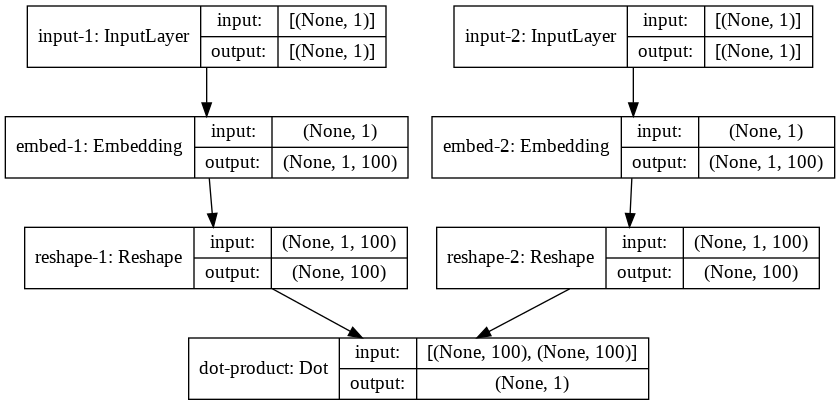

In [75]:
plot_model(model)

In [76]:
from keras.models import load_model
import os
def save_model(model, name):
  model_name = '{}.h5'.format(name)
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  
  # Save model and weights
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at %s ' % model_path)

In [77]:
save_model(model, 'weights') #save baseline CNN model

Saved trained model at /content/saved_models/weights.h5 


In [78]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model.compile(loss='mse', optimizer='adamax')
callbacks = [EarlyStopping('val_loss', patience=2), ModelCheckpoint('weights.h5', save_best_only=True)]

In [79]:
history = model.fit([Users, Movies], Ratings, epochs=30, validation_split=.1, verbose=2, callbacks=callbacks)

Epoch 1/30
28131/28131 - 68s - loss: 13.7453 - val_loss: 12.2043
Epoch 2/30
28131/28131 - 66s - loss: 8.0260 - val_loss: 5.0409
Epoch 3/30
28131/28131 - 66s - loss: 3.7565 - val_loss: 2.8926
Epoch 4/30
28131/28131 - 66s - loss: 2.3846 - val_loss: 2.0458
Epoch 5/30
28131/28131 - 66s - loss: 1.7850 - val_loss: 1.6270
Epoch 6/30
28131/28131 - 65s - loss: 1.4677 - val_loss: 1.3877
Epoch 7/30
28131/28131 - 64s - loss: 1.2787 - val_loss: 1.2383
Epoch 8/30
28131/28131 - 64s - loss: 1.1568 - val_loss: 1.1375
Epoch 9/30
28131/28131 - 64s - loss: 1.0734 - val_loss: 1.0672
Epoch 10/30
28131/28131 - 64s - loss: 1.0137 - val_loss: 1.0157
Epoch 11/30
28131/28131 - 64s - loss: 0.9690 - val_loss: 0.9767
Epoch 12/30
28131/28131 - 64s - loss: 0.9344 - val_loss: 0.9465
Epoch 13/30
28131/28131 - 64s - loss: 0.9066 - val_loss: 0.9222
Epoch 14/30
28131/28131 - 63s - loss: 0.8837 - val_loss: 0.9024
Epoch 15/30
28131/28131 - 64s - loss: 0.8643 - val_loss: 0.8852
Epoch 16/30
28131/28131 - 64s - loss: 0.8473 - 

In [80]:
# RMSE
# Show the best validation RMSE
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 30 = 0.8788
